# A deep learning framework for the prediction of post-accident hospitalization of construction workers
## Contents
 •	Introduction 
 
 •	Exploratory Data Analysis
 
 •	Data Preprocessing
 
 •	CART Feature Importance
 
 •	Baseline Models
 
 •	Hyperparameter Tuning

## Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              ExtraTreesClassifier)
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
import xgboost as xgb
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
%matplotlib inline
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
plt.style.use('ggplot')


# 1. Introduction
## 1.1 Data
Data for the severe injury reporting program was accessed from its official webpage (https://www.osha.gov/severeinjury) in July 2024. The site contained all severe injury reports submitted between January 1, 2015, and November 30, 2023. This dataset comprised over 87,000 injury reports from a variety of industries. Each report included employer and workplace details, along with a North American Industry Classification System (NAICS) code, which clarified the industry context of each incident. For this study, incidents from the construction industry (NAICS Sector 23) were isolated, resulting in 15,680 relevant incident reports.

In [2]:
#Read Data
df = pd.read_csv(r"C:\Users\obasi\Desktop\January2015toNovember2023.csv",encoding='cp1252', low_memory=False)
df.head() 

,ID,UPA,EventDate,Employer,Address1,Address2,City,State,Zip,Latitude,Longitude,Primary NAICS,Hospitalized,Amputation,Inspection,Final Narrative,Nature,NatureTitle,Part of Body,Part of Body Title,Event,EventTitle,Source,SourceTitle,Secondary Source,Secondary Source Title,FederalState
0,2015010015,931176,1/1/2015,FCI Otisville Federal Correctional Institution,Two Mile Drive,NaN,OTISVILLE,NEW YORK,10963.0,41.46,-74.53,922140,1.0,0.0,1018519.0,Three correctional facility guards were escort...,111,Fractures,513,Lower leg(s),1214,Injured by physical contact with person while ...,5721,Co-worker,5772.0,Inmate or detainee in custody,1
1,2015010016,930267,1/1/2015,Kalahari Manufacturing LLC,171 Progress Drive,NaN,LAKE DELTON,WISCONSIN,53940.0,43.59,-89.79,339999,1.0,0.0,1016582.0,Employee in the Machine Shop received second d...,1522,Second degree heat (thermal) burns,519,"Leg(s), n.e.c.",317,"Ignition of vapors, gases, or liquids",7261,"Welding, cutting, and blow torches",NaN,NaN,1
2,2015010018,929823,1/1/2015,Schneider National Bulk Carrier,420 CORAOPOLIS ROAD,NaN,CORAOPOLIS,PENNSYLVANIA,15108.0,40.49,-80.11,484121,1.0,0.0,NaN,A truck driver fell approximately 4 feet while...,10,"Traumatic injuries and disorders, unspecified",9999,Nonclassifiable,4331,Other fall to lower level less than 6 feet,8421,"Semi, tractor-trailer, tanker truck",741.0,Ladders-fixed,1
3,2015010019,929711,1/1/2015,PEPSI BOTTLING GROUP INC.,4541 HOUSTON AVE.,NaN,MACON,GEORGIA,31206.0,32.77,-83.65,424490,1.0,0.0,1017194.0,An employee's leg was pinned between a truck a...,1972,"Soreness, pain, hurt-nonspecified injury",510,"Leg(s), unspecified",640,Caught in or compressed by equipment or object...,8623,Pallet jack-powered,8420.0,"Truck-motorized freight hauling and utility, u...",1
4,2015010020,929642,1/1/2015,North American Pipe Corporation,210 South Arch Street,NaN,JANESVILLE,WISCONSIN,53545.0,42.67,-89.04,326122,1.0,0.0,1016344.0,An employee working on the Line 6 Auto-Beller ...,111,Fractures,4429,"Finger(s), fingernail(s), n.e.c.",6411,Caught in running equipment or machinery durin...,350,"Metal, woodworking, and special material machi...",NaN,NaN,1


## 1.2 Project Objectives
This paper proposes a deep neural network (DNN) classifier enhanced by the adaptive moment estimation (ADAM) algorithm for predicting post-accident hospitalization among construction workers. ADAM is chosen for its advantages, including a bias correction mechanism that adjusts for initial bias in moment estimates (mean and variance) during the early training stages.

The primary contributions of this paper are as follows:

•	The goal of this study is to predict the likelihood of hospitalization for construction workers following accidents using a binary classification approach. This is achieved by applying a deep neural network and five additional tree-based ensemble machine-learning algorithms. The core focus is to determine whether construction workers will be temporarily unable to perform their duties due to accidents. The model, designed with the practical needs of construction companies and relevant institutions in mind, is a valuable tool following occupational incidents. There is a gap in research concerning the use of deep learning for predicting post-accident hospitalization outcomes in construction workers, and this model aims to fill that gap.

•	Optimization techniques in deep learning have been shown to improve predictive models in different ways [13,14]. However, their use for correcting data bias in construction safety management remains unexplored. This paper aims to create a deep neural network optimized with the ADAM algorithm to predict construction workers' post-accident hospitalization outcomes, focusing on accurately predicting the minority class.

•	Tree-based ensemble models have gained prominence as advanced machine learning techniques, with CatBoost and XGBoost being particularly noted for their outstanding performance across different fields. Previous studies have consistently highlighted the effectiveness of these algorithms [15–18]. This research intends to evaluate and compare the performance of a deep neural network model against these tree-based ensemble models, using the f1 score as the key performance metric.

•	This research utilizes an advanced grid search algorithm for fine-tuning parameters across all models employed in the study. Grid search has proven effective in enhancing predictive models, particularly in construction. The decision to use grid search in this study stems from its capability to exhaustively explore every possible combination of parameters, offering an advantage over other optimization methods that might overlook the optimal set by relying on approximations or incomplete searches. By integrating grid search with the DNN and tree-based ensemble models, the study aims to enhance the performance of these models, ultimately contributing to developing more effective safety management strategies and fostering a safer working environment for construction workers.


## Exploratory Data Analysis

### 2.1 Basic Data Exploration

In [3]:
print("Shape of the Data: {} ". format(df.shape))

Shape of the Data: (87691, 27) 


In [4]:
df.columns

Index(['ID', 'UPA', 'EventDate', 'Employer', 'Address1', 'Address2', 'City',
       'State', 'Zip', 'Latitude', 'Longitude', 'Primary NAICS',
       'Hospitalized', 'Amputation', 'Inspection', 'Final Narrative', 'Nature',
       'NatureTitle', 'Part of Body', 'Part of Body Title', 'Event',
       'EventTitle', 'Source', 'SourceTitle', 'Secondary Source',
       'Secondary Source Title', 'FederalState'],
      dtype='object')

In [5]:
df.dtypes

ID                          int64
UPA                         int64
EventDate                  object
Employer                   object
Address1                   object
Address2                   object
City                       object
State                      object
Zip                       float64
Latitude                  float64
Longitude                 float64
Primary NAICS              object
Hospitalized              float64
Amputation                float64
Inspection                float64
Final Narrative            object
Nature                      int64
NatureTitle                object
Part of Body                int64
Part of Body Title         object
Event                       int64
EventTitle                 object
Source                      int64
SourceTitle                object
Secondary Source          float64
Secondary Source Title     object
FederalState                int64
dtype: object

In [6]:
print("Number of integer columns: {} ". format(df.dtypes.tolist().count(df.dtypes[0])))
print("Number of object columns: {} ". format(df.dtypes.tolist().count(df.dtypes[20])))

Number of integer columns: 7 
Number of object columns: 7 


In [7]:
df.rename(columns = {'Primary NAICS': 'Primary_NAICS', 'Final Narrative': 'Final_Narrative', 'Part of Body': 'Part_of_Body', 'Secondary Source': 'Secondary_Source'}, inplace = True)

In [8]:
duplicate = df[df.duplicated()== True]
print("Number of duplicate rows: {} ".format(len(duplicate)))

Number of duplicate rows: 0 


In [9]:
df.isna().sum()

ID                            0
UPA                           0
EventDate                     0
Employer                      0
Address1                     17
Address2                  79865
City                         16
State                         0
Zip                          23
Latitude                     86
Longitude                    86
Primary_NAICS                 2
Hospitalized                  0
Amputation                    7
Inspection                58154
Final_Narrative               0
Nature                        0
NatureTitle                   0
Part_of_Body                  0
Part of Body Title            0
Event                         0
EventTitle                    0
Source                        0
SourceTitle                   0
Secondary_Source          55090
Secondary Source Title    55090
FederalState                  0
dtype: int64

In [10]:
print("Total number of missing values: {}".format(df.isna().sum().sum()))
print("Number of columns with missing values: {}".format(len([col for col in df.columns if df[col].isnull().sum() > 0])))
print("Number of columns without missing values: {}".format(len([col for col in df.columns if df[col].isnull().sum() == 0])))

Total number of missing values: 248436
Number of columns with missing values: 11
Number of columns without missing values: 16


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87691 entries, 0 to 87690
Data columns (total 27 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      87691 non-null  int64  
 1   UPA                     87691 non-null  int64  
 2   EventDate               87691 non-null  object 
 3   Employer                87691 non-null  object 
 4   Address1                87674 non-null  object 
 5   Address2                7826 non-null   object 
 6   City                    87675 non-null  object 
 7   State                   87691 non-null  object 
 8   Zip                     87668 non-null  float64
 9   Latitude                87605 non-null  float64
 10  Longitude               87605 non-null  float64
 11  Primary_NAICS           87689 non-null  object 
 12  Hospitalized            87691 non-null  float64
 13  Amputation              87684 non-null  float64
 14  Inspection              29537 non-null

In [12]:
print("Number of duplicate observations: {}".format(df.duplicated().sum()))

Number of duplicate observations: 0


In [13]:
# Using map function to make the values 0: non-hospitalized and 1: hospitalized
df['Hospitalized'] = df['Hospitalized'].map({0.0: 0, 1.0: 1, 2.0:1})
#Lets check the counts of the values in predictor variable
df.Hospitalized.value_counts()

1.0    70951
0.0    16722
Name: Hospitalized, dtype: int64

## 2.2. Selecting Construction (Primary NAICS: 23)
The dataset was analyzed to extract incidents from the construction industry (NAICS Sector 23). This process resulted in a dataset comprising 15680 construction accident records, consisting of 14018 hospitalized and 1659 non-hospitalized instances

In [14]:
#We need to consider only accidents that happened in the construction industry (Primary NAICS: '23')

# First drop rows where 'Primary_NAICS' is NaN
df_cleaned = df.dropna(subset=['Primary_NAICS'])

# Filter rows where 'Primary_NAICS' starts with '23'
filtered_df = df_cleaned[df_cleaned['Primary_NAICS'].str.startswith('23')]

print(filtered_df)

                ID      UPA   EventDate                           Employer  \
13      2015010029   929833    1/2/2015        KEYSTONE CONCRETE PLACEMENT   
19      2015010037   929890    1/2/2015           DYNAMIC INDUSTRIES, INC.   
23      2015010043   929932    1/3/2015         Northstar Contracting Inc.   
45      2015010068   930344    1/5/2015             TROY CONSTRUCTION, LLC   
50      2015010073   930324    1/5/2015            Insulation Incorporated   
...            ...      ...         ...                                ...   
87660  20231110941  2107801  11/30/2023  Northern Metal & Roofing Co. Inc.   
87663  20231110944  2107975  11/30/2023                   NPSG Global, LLC   
87666  20231110947  2108003  11/30/2023                 Hooper Corporation   
87674  20231110956  2107520  11/30/2023      Epoxy Coating Specialists Inc   
87684  20231110968  2108203  11/30/2023                        Nucos Pools   

                       Address1                      Address2  

In [15]:
df = filtered_df

In [16]:
#Recheck the counts of the values in predictor variable based on NAICS 23
df.Hospitalized.value_counts()

1.0    14018
0.0     1659
Name: Hospitalized, dtype: int64

## 2.3. Data Visualization
### The target variable: Hospitalized
The ***Hospitalized*** is a categorical variable with two possible values.

In [17]:
df.Hospitalized.value_counts()

1.0    14018
0.0     1659
Name: Hospitalized, dtype: int64

In [18]:
# Add annotations function
def add_annotations(ax):
    for p in ax.patches:
        frequency = int(p.get_height())
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(f'{frequency}', (x, y), size=12, ha='center', va='bottom')

# Visualization function
def count_donut(data, col):
    plt.figure(figsize=(14, 7))

    # Countplot
    ax1 = plt.subplot(1, 2, 1)
    count = sns.countplot(x=data[col])
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    sns.despine(top=True, right=True)
    add_annotations(ax1)

    # Donutplot
    ax2 = plt.subplot(1, 2, 2)
    
    # Get value counts and corresponding labels
    value_counts = data[col].value_counts()
    labels = value_counts.index.tolist()
    sizes = value_counts.values
    
    plt.pie(sizes,
            labels=labels,
            autopct='%1.2f%%',
            pctdistance=0.8,
            shadow=False,
            radius=1.3,
            textprops={'fontsize': 14}
            )
    circle = plt.Circle((0, 0), 0.4, fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(circle)
    ax2.set_xlabel('')

    plt.suptitle(f"Frequency Comparison of {col}", fontsize=16)
    plt.subplots_adjust(wspace=0.4)
    plt.show()

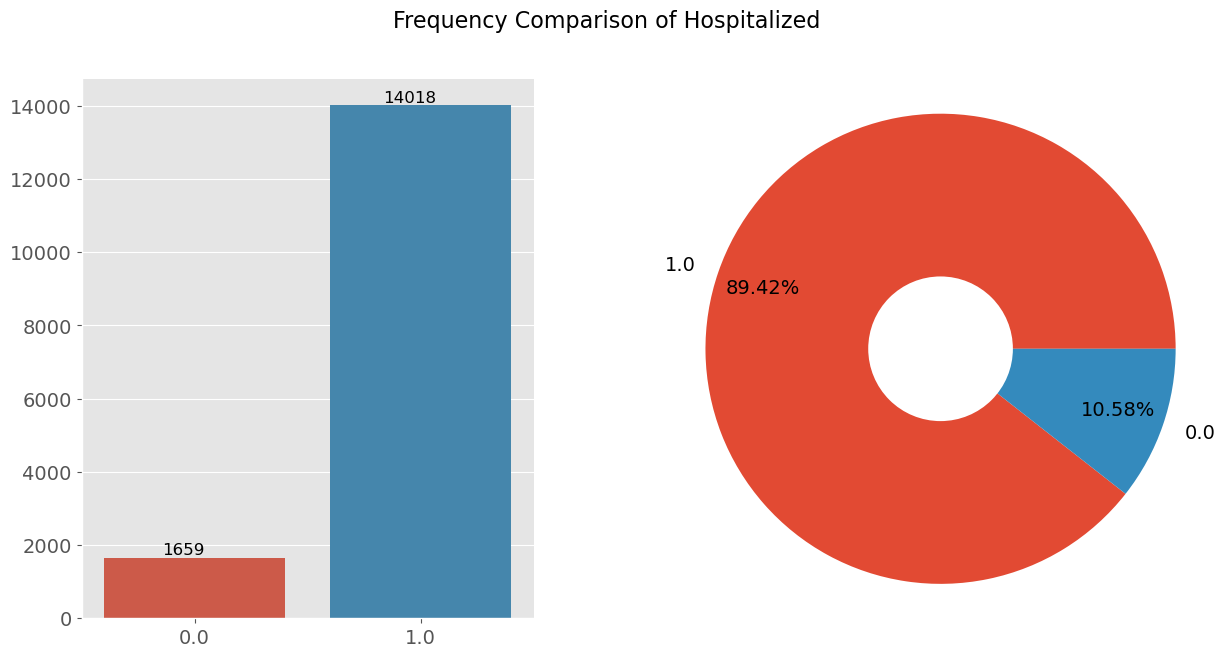

In [19]:
count_donut(df, 'Hospitalized')

**The charts indicate that the data concerning the target variable (Hospitalized) is imbalanced**. Most accidents fall into the hospitalized category, accounting for 89.42% of the instances. Then the non-hospitalized accident accounting for 10.58% of the dataset. Next, we will explore the various feature variables to understand how the target variable behaves in relation to changes in these features.

## 3. Data Preprocessing
### 3.1 Missing Data Imputation

In [20]:
unneeded_columns = ['UPA', 'ID', 'EventDate', 'Address1', 'Part of Body Title', 'Employer', 'Address2', 'City', 'State', 'Zip', 'Latitude', 'Longitude', 'NatureTitle', 'Final_Narrative', 'Inspection', 'SourceTitle', 'Secondary_Source', 'Secondary Source Title', 'EventTitle', 'FederalState']

df = df.drop(unneeded_columns, axis=1)

In [21]:
# Combining similar values
def combine_similar(df):
    df = df.replace('Unknown', 'unknown')
    df = df.replace('Other', 'other')
    df = df.replace('Unknown or other', 'other')
    return df

In [22]:
df = combine_similar(df)

In [23]:
# Columns with missing values (sorted by count)
df.isna().sum()[df.isna().sum() != 0].sort_values(ascending = False)

Hospitalized    3
Amputation      2
dtype: int64

In [24]:
# Rows with missing values (sorted by count)
df.T.isna().sum()[df.T.isna().sum() != 0].sort_values(ascending = False)

45169    1
60921    1
61270    1
65861    1
67010    1
dtype: int64

In [25]:
# Converting unknown/other/na to nan
def more_missing(df):
    df = df.replace('unknown', np.nan)
    df = df.replace('other', np.nan)
    df = df.replace('na', np.nan)
    return df

In [26]:
df = more_missing(df)

In [27]:
def mode_imputer(df):
    df_imputed = df.copy(deep = True)
    imputer = SimpleImputer(strategy = 'most_frequent')
    data_imputed.iloc[:,:] = imputer.fit_transform(df_imputed)
    return df_imputed

In [28]:
# Function to assign the missing values to the 'unknown' category
def unknown_imputer(df):
    df_unknown = df.copy(deep = True)
    df_unknown = df_unknown.replace(np.nan, 'Unknown')
    return df_unknown

In [29]:
def prop_imputer(df):
    df_prop = df.copy(deep = True)
    missing_cols = df_prop.isna().sum()[df_prop.isna().sum() != 0].index.tolist()
    for col in missing_cols:
        values_col = df_prop[col].value_counts(normalize = True).index.tolist()
        probabilities_col = df_prop[col].value_counts(normalize = True).values.tolist()
        df_prop[col] = df_prop[col].fillna(pd.Series(np.random.choice(values_col, p = probabilities_col, size = len(df))))
    return df_prop

In [30]:
df_imp = prop_imputer(df)

C:\Users\obasi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\obasi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


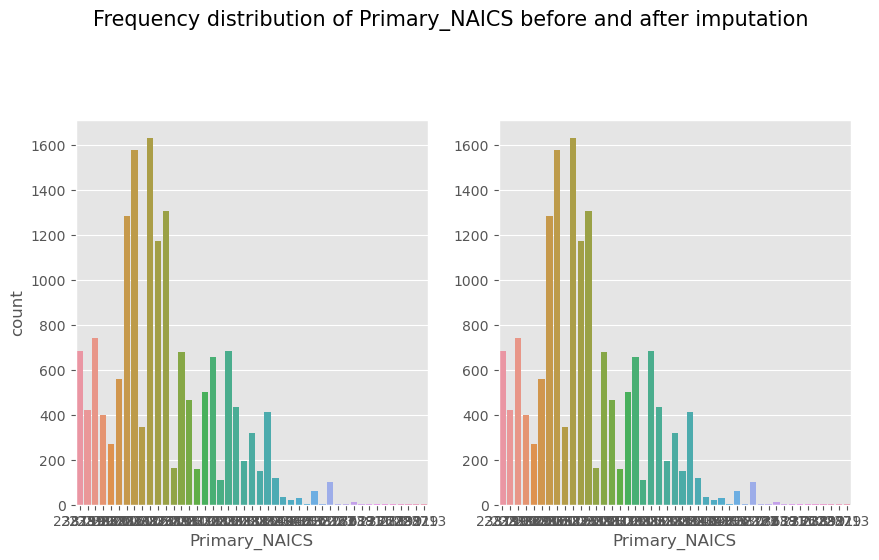

C:\Users\obasi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\obasi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


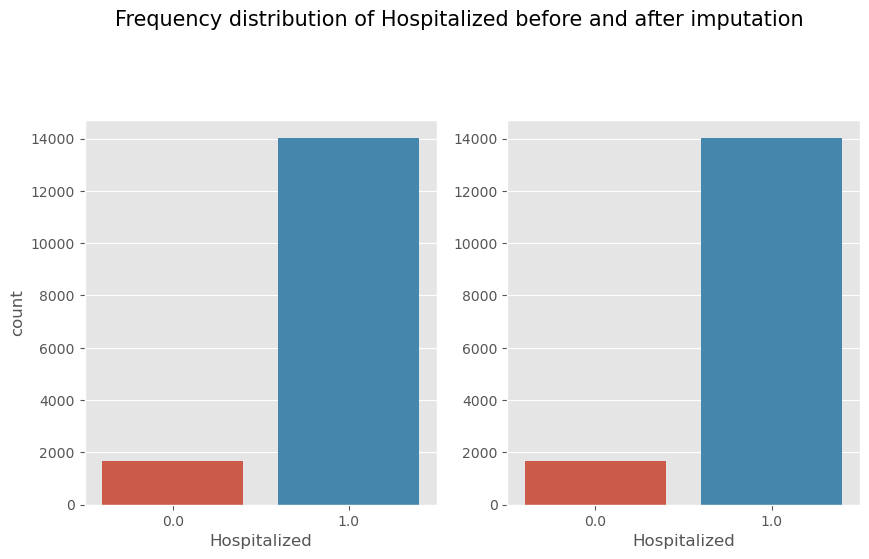

C:\Users\obasi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\obasi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


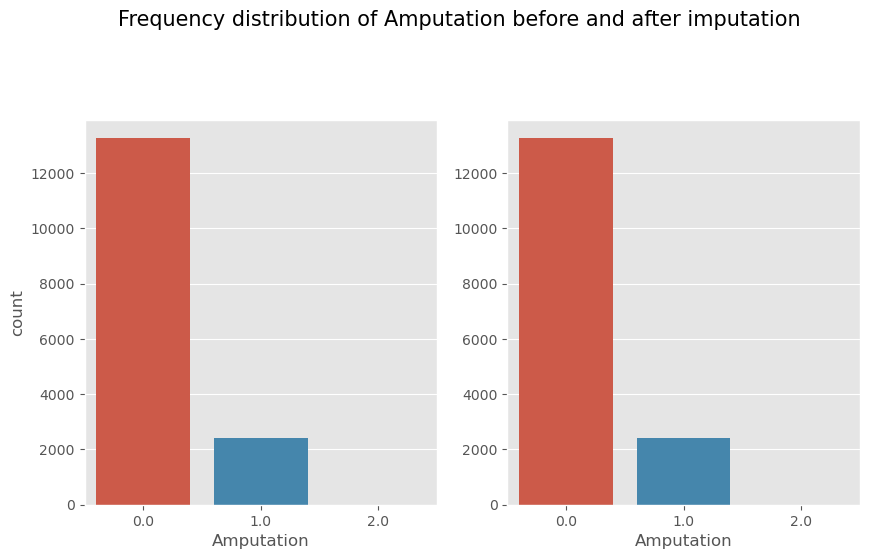

C:\Users\obasi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\obasi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


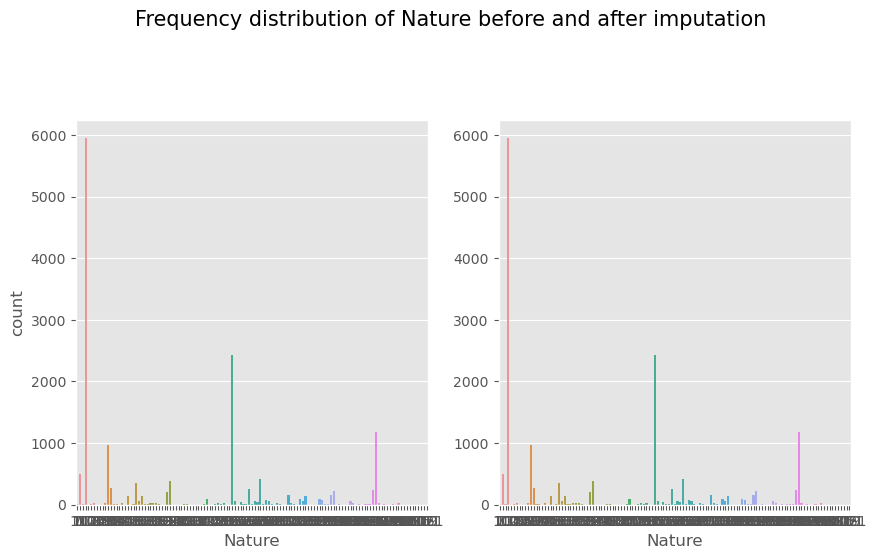

C:\Users\obasi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\obasi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


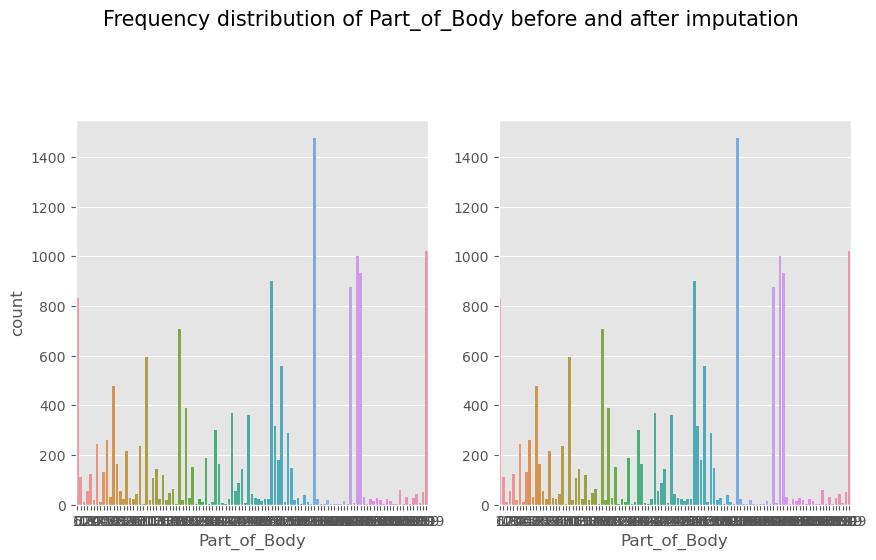

C:\Users\obasi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\obasi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


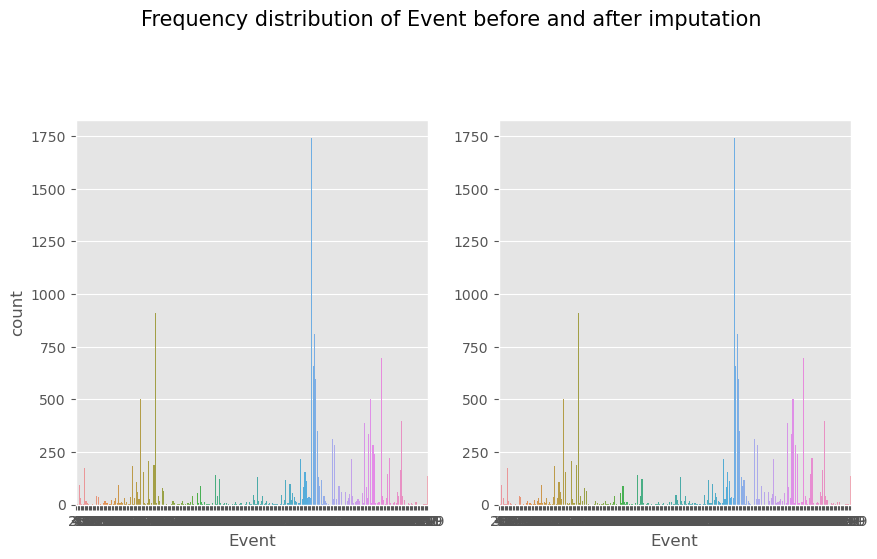

C:\Users\obasi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\obasi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


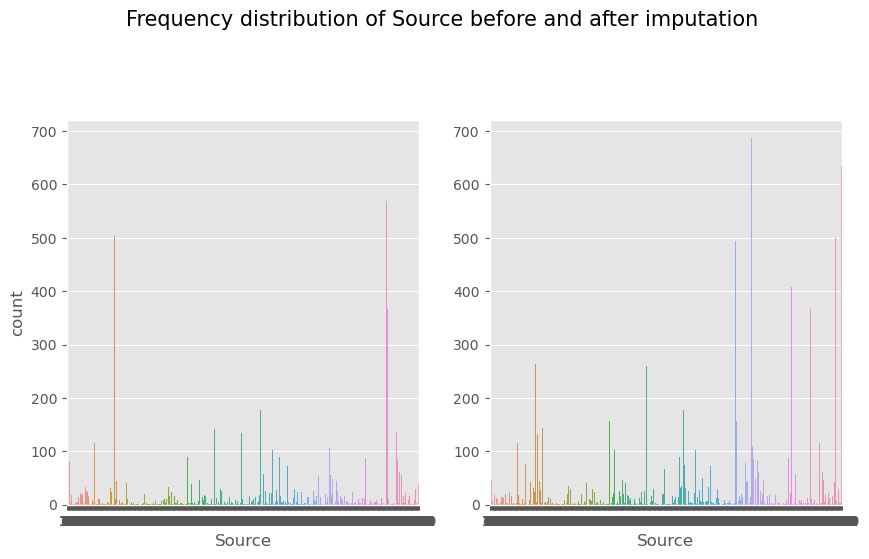

In [31]:
# Variables except 'Accident_severity' and 'Time'
features_others = [x for x in df.columns.tolist() if x not in ['Degree_of_Injury']]
for feature in features_others:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    ax1 = sns.countplot(df[feature], ax = ax1)
    ax2 = sns.countplot(df_imp[feature], ax = ax2)
    ax2.set_ylabel('')
    plt.suptitle("Frequency distribution of {} before and after imputation".format(feature), y = 1.1, fontsize = 15)
    plt.show()

In [32]:
#Check and count rows of missing data for each column
missing_number=df.isnull().sum().sort_values(ascending=False)

#Calculate percentage of null value
missing_percentage=missing_number/len(df)
missing_info=pd.concat([missing_number,missing_percentage],axis=1,keys=['missing number','missing percentage'])
missing_info.head(20)

,missing number,missing percentage
Hospitalized,3,0.000191
Amputation,2,0.000128
Primary_NAICS,0,0.000000
Nature,0,0.000000
Part_of_Body,0,0.000000
Event,0,0.000000
Source,0,0.000000


In [33]:
# Separate numerical and categorical columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object', 'category']).columns

# Handling missing values for numerical columns
num_imputer = SimpleImputer(strategy='mean')  # You can change 'mean' to 'median' or 'constant'
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# Handling missing values for categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')  # You can change 'most_frequent' to 'constant' and add fill_value='missing'
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# Check if there are any remaining missing values
print(df.isnull().sum())

Primary_NAICS    0
Hospitalized     0
Amputation       0
Nature           0
Part_of_Body     0
Event            0
Source           0
dtype: int64


### 3.2 Categorical Data Encoding
We employed Label encoding to convert categorical variables into numerical values. The standard-scaler method was employed for feature scaling in this study. The Standard-scaler transforms numeric features to yield a distribution with a mean value of 0 and a standard deviation of 1.

In [34]:
#Get list of categorical variables
s=(df.dtypes=='object')
object_cols=list(s[s].index)
print("Categorical variables in the dataset:",object_cols)

#Label Encoding the categorical varibles
LE=LabelEncoder()
for i in object_cols:
    df[i]=df[[i]].apply(LE.fit_transform)
print("All Features are now numerical")

# Standard Scaling
scaler=StandardScaler()
scaler.fit(df)
scaled_ds=pd.DataFrame(scaler.transform(df),columns=df.columns)
print("All features are now scaled")

Categorical variables in the dataset: ['Primary_NAICS']
All Features are now numerical
All features are now scaled


<AxesSubplot:>

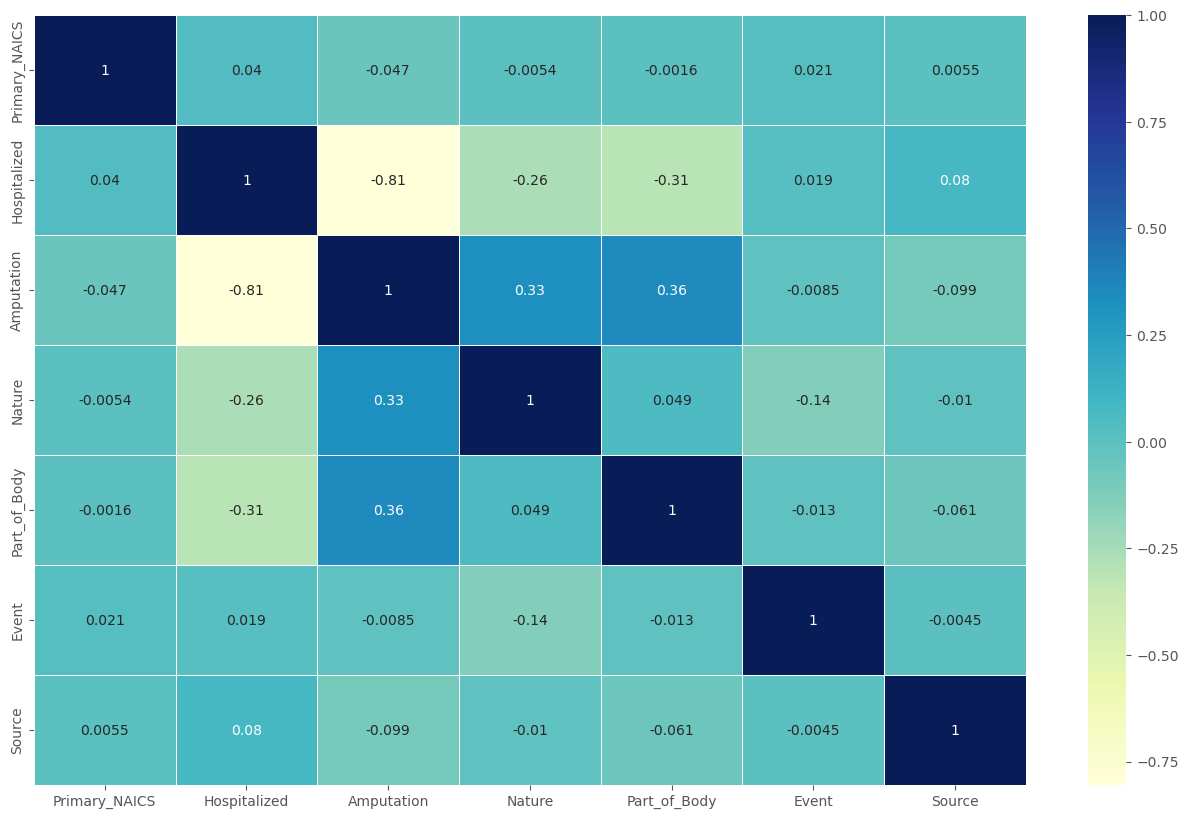

In [35]:
plt.figure(figsize=(16,10))
sns.heatmap(df.corr(),annot=True,linewidth=.5,cmap='YlGnBu')

### 3.3 Feature Importance Selection 
This study utilized the CART model to identify key variables before predicting the "Hospitalized". Feature selection was conducted for the target variable: 'Hospitalized' and 'Amputation'. The x-axis represents the importance of each variable using z-scores, and the y-axis lists the corresponding variables. The importance rankings indicate the relative contribution of each feature within the CART model.

Most significant features for Amputation based on CART:
         Feature  Importance
1         Nature    0.571349
2   Part_of_Body    0.400054
4         Source    0.012383
0  Primary_NAICS    0.009131
3          Event    0.007082
Most significant features for Hospitalized based on CART:
         Feature  Importance
1         Nature    0.378409
2   Part_of_Body    0.311891
4         Source    0.137769
0  Primary_NAICS    0.103295
3          Event    0.068635


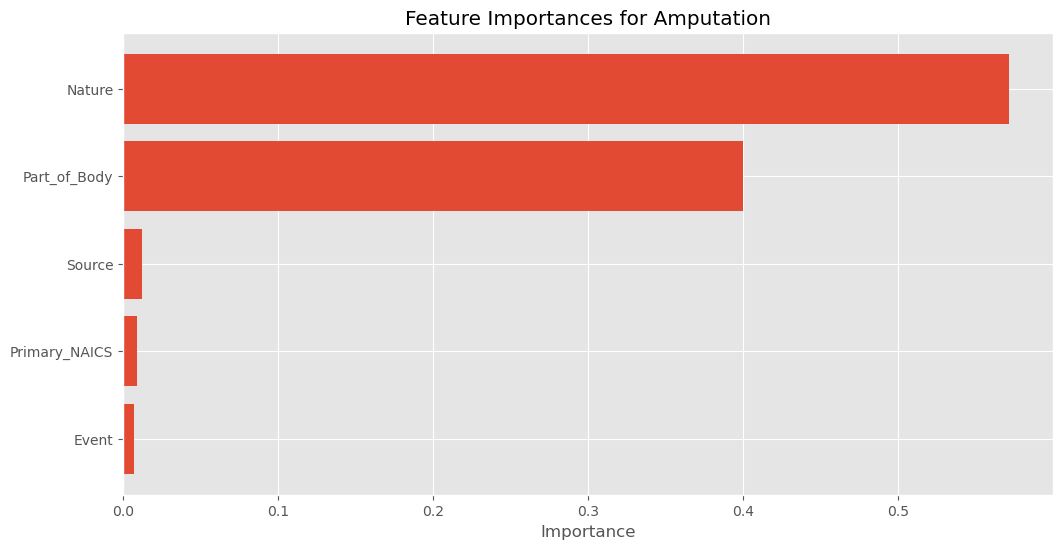

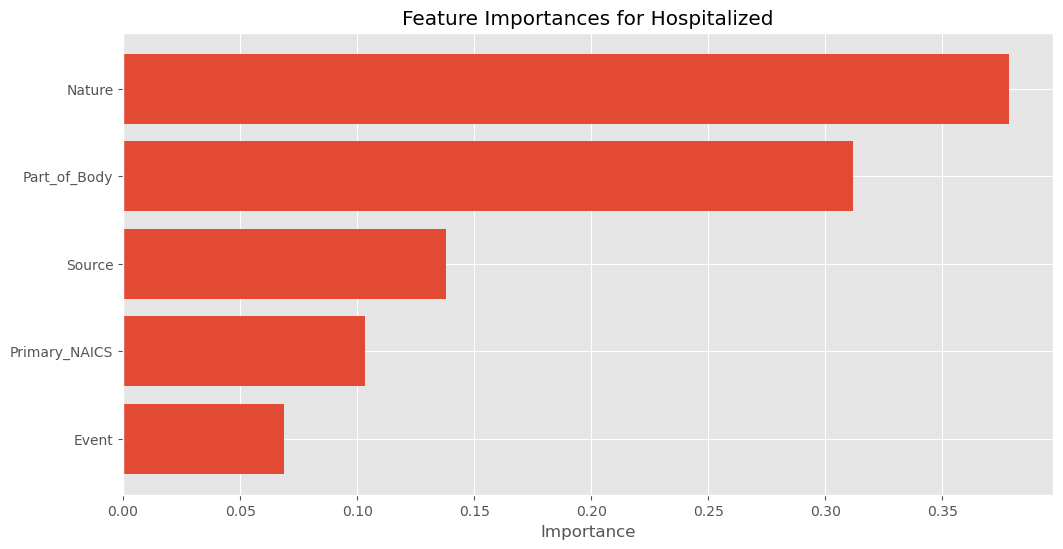

In [36]:


# Define the target variables
target_amputation = 'Amputation'
target_hospitalized = 'Hospitalized'

# Preprocessing the target variables
label_encoder_amputation = LabelEncoder()
df[target_amputation] = label_encoder_amputation.fit_transform(df[target_amputation])

label_encoder_hospitalized = LabelEncoder()
df[target_hospitalized] = label_encoder_hospitalized.fit_transform(df[target_hospitalized])

# Set X and y for Amputation
y_amputation = df[target_amputation]
X_amputation = df.drop([target_amputation, target_hospitalized], axis=1)

# Set X and y for Hospitalized
y_hospitalized = df[target_hospitalized]
X_hospitalized = df.drop([target_amputation, target_hospitalized], axis=1)

# Handle non-numeric columns for Amputation
for column in X_amputation.columns:
    if X_amputation[column].dtype == 'object':
        X_amputation[column] = LabelEncoder().fit_transform(X_amputation[column])

# Handle non-numeric columns for Hospitalized
for column in X_hospitalized.columns:
    if X_hospitalized[column].dtype == 'object':
        X_hospitalized[column] = LabelEncoder().fit_transform(X_hospitalized[column])

# Fit a DecisionTreeClassifier to select important features for Amputation
tree_amputation = DecisionTreeClassifier(random_state=42)
tree_amputation.fit(X_amputation, y_amputation)

# Get feature importances for Amputation
importances_amputation = tree_amputation.feature_importances_
feature_names_amputation = X_amputation.columns

# Create a DataFrame for feature importances for Amputation
feature_importances_amputation = pd.DataFrame({'Feature': feature_names_amputation, 'Importance': importances_amputation})
feature_importances_amputation = feature_importances_amputation.sort_values(by='Importance', ascending=False)

# Print the most significant features for Amputation
print("Most significant features for Amputation based on CART:")
print(feature_importances_amputation)

# Fit a DecisionTreeClassifier to select important features for Hospitalized
tree_hospitalized = DecisionTreeClassifier(random_state=42)
tree_hospitalized.fit(X_hospitalized, y_hospitalized)

# Get feature importances for Hospitalized
importances_hospitalized = tree_hospitalized.feature_importances_
feature_names_hospitalized = X_hospitalized.columns

# Create a DataFrame for feature importances for Hospitalized
feature_importances_hospitalized = pd.DataFrame({'Feature': feature_names_hospitalized, 'Importance': importances_hospitalized})
feature_importances_hospitalized = feature_importances_hospitalized.sort_values(by='Importance', ascending=False)

# Print the most significant features for Hospitalized
print("Most significant features for Hospitalized based on CART:")
print(feature_importances_hospitalized)

# Plot feature importances for Amputation
plt.figure(figsize=(12, 6))
plt.barh(feature_importances_amputation['Feature'], feature_importances_amputation['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances for Amputation')
plt.gca().invert_yaxis()
plt.show()

# Plot feature importances for Hospitalized
plt.figure(figsize=(12, 6))
plt.barh(feature_importances_hospitalized['Feature'], feature_importances_hospitalized['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances for Hospitalized')
plt.gca().invert_yaxis()
plt.show()


## 4. Models
First, we established the predictor-target split. The dataset was then divided into two parts, with 70% allocated for training and validation and the remaining 30% reserved for testing the final model's performance. To mitigate data bias, we utilized Adam optimization for the deep neural network and applied SMOTE to handle class imbalance in the tree-based ensemble machine learning models. Additionally, grid search was employed to identify the optimal hyperparameters across all models, ensuring the highest possible accuracy.

In [37]:
# Set the target for the prediction
target = 'Hospitalized'

# Load your dataset
# df = pd.read_csv('your_dataset.csv')

# Set X and y
y = df[target]
X = df.drop(target, axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
# Check unique values in the original target column
print("Unique values in the target column before split:", y.unique())

Unique values in the target column before split: [2 0 1]


In [39]:
# Map class `2` to `1` if `2` is considered equivalent to `1`
df[target] = df[target].map({0: 0, 1: 1, 2: 1})

# Check unique values after mapping
print("Unique values after mapping:", df[target].unique())

Unique values after mapping: [1 0]


In [40]:
df[target] = df[target].map({0: 0, 1: 1, 2: 1})
y = df[target]
X = df.drop(target, axis=1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE to the training data for tree-based models
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1. ADAM optimized DNN (using original data)
def build_dnn_model(optimizer='adam'):
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

dnn_model = KerasClassifier(build_fn=build_dnn_model, verbose=0)
dnn_params = {
    'epochs': [50, 100],
    'batch_size': [32, 64],
    'optimizer': ['adam', Adam(learning_rate=0.001)]
}

dnn_grid = GridSearchCV(estimator=dnn_model, param_grid=dnn_params, cv=cv, n_jobs=-1, verbose=2)
dnn_grid.fit(X_train_scaled, y_train)
dnn_pred_proba = dnn_grid.predict_proba(X_test_scaled)[:, 1]
dnn_pred = (dnn_pred_proba > 0.5).astype("int32")

print("ADAM optimized DNN classification report:")
print(classification_report(y_test, dnn_pred, digits=4))
print("Best parameters:", dnn_grid.best_params_)

# 2. Random Forest (using SMOTE data)
rf = RandomForestClassifier(random_state=42)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid = GridSearchCV(estimator=rf, param_grid=rf_params, cv=cv, n_jobs=-1, verbose=2)
rf_grid.fit(X_train_smote, y_train_smote)
rf_pred_proba = rf_grid.predict_proba(X_test_scaled)[:, 1]
rf_pred = rf_grid.predict(X_test_scaled)

print("Random Forest classification report:")
print(classification_report(y_test, rf_pred, digits=4))
print("Best parameters:", rf_grid.best_params_)

# 3. XGBoost (using SMOTE data)
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 6],
    'colsample_bytree': [0.3, 0.7]
}

xgb_grid = GridSearchCV(estimator=xgb_model, param_grid=xgb_params, cv=cv, n_jobs=-1, verbose=2)
xgb_grid.fit(X_train_smote, y_train_smote)
xgb_pred_proba = xgb_grid.predict_proba(X_test_scaled)[:, 1]
xgb_pred = xgb_grid.predict(X_test_scaled)

print("XGBoost classification report:")
print(classification_report(y_test, xgb_pred, digits=4))
print("Best parameters:", xgb_grid.best_params_)

# 4. CatBoost (using SMOTE data)
catboost_model = CatBoostClassifier(random_state=42, silent=True)
catboost_params = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'depth': [3, 6, 10]
}

catboost_grid = GridSearchCV(estimator=catboost_model, param_grid=catboost_params, cv=cv, n_jobs=-1, verbose=2)
catboost_grid.fit(X_train_smote, y_train_smote)
catboost_pred_proba = catboost_grid.predict_proba(X_test)[:, 1]
catboost_pred = catboost_grid.predict(X_test)

print("CatBoost classification report:")
print(classification_report(y_test, catboost_pred, digits=4))
print("Best parameters:", catboost_grid.best_params_)

# 5. AdaBoost (using SMOTE data)
adaboost_model = AdaBoostClassifier(random_state=42)
adaboost_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1, 1.0]
}

adaboost_grid = GridSearchCV(estimator=adaboost_model, param_grid=adaboost_params, cv=cv, n_jobs=-1, verbose=2)
adaboost_grid.fit(X_train_smote, y_train_smote)
adaboost_pred_proba = adaboost_grid.predict_proba(X_test_scaled)[:, 1]
adaboost_pred = adaboost_grid.predict(X_test_scaled)

print("AdaBoost classification report:")
print(classification_report(y_test, adaboost_pred, digits=4))
print("Best parameters:", adaboost_grid.best_params_)

# 6. Extra Trees (using SMOTE data)
extra_trees_model = ExtraTreesClassifier(random_state=42)
extra_trees_params = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

extra_trees_grid = GridSearchCV(estimator=extra_trees_model, param_grid=extra_trees_params, cv=cv, n_jobs=-1, verbose=2)
extra_trees_grid.fit(X_train_smote, y_train_smote)
extra_trees_pred_proba = extra_trees_grid.predict_proba(X_test_scaled)[:, 1]
extra_trees_pred = extra_trees_grid.predict(X_test_scaled)

print("Extra Trees classification report:")
print(classification_report(y_test, extra_trees_pred, digits=4))
print("Best parameters:", extra_trees_grid.best_params_)



Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\obasi\AppData\Local\Temp\ipykernel_22788\1877629957.py:29: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  dnn_model = KerasClassifier(build_fn=build_dnn_model, verbose=0)


147/147 [==============================] - 1s 2ms/step
ADAM optimized DNN classification report:
              precision    recall  f1-score   support

           0     0.7089    0.9476    0.8110       496
           1     0.9936    0.9541    0.9735      4208

    accuracy                         0.9534      4704
   macro avg     0.8512    0.9509    0.8922      4704
weighted avg     0.9636    0.9534    0.9563      4704

Best parameters: {'batch_size': 32, 'epochs': 50, 'optimizer': 'adam'}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Random Forest classification report:
              precision    recall  f1-score   support

           0     0.6965    0.9577    0.8065       496
           1     0.9948    0.9508    0.9723      4208

    accuracy                         0.9515      4704
   macro avg     0.8456    0.9542    0.8894      4704
weighted avg     0.9633    0.9515    0.9548      4704

Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split'

C:\Users\obasi\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\obasi\anaconda3\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBoost classification report:
              precision    recall  f1-score   support

           0     0.6955    0.9718    0.8108       496
           1     0.9965    0.9499    0.9726      4208

    accuracy                         0.9522      4704
   macro avg     0.8460    0.9608    0.8917      4704
weighted avg     0.9648    0.9522    0.9556      4704

Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100}
Fitting 5 folds for each of 12 candidates, totalling 60 fits
CatBoost classification report:
              precision    recall  f1-score   support

           0     0.6841    1.0000    0.8124       496
           1     1.0000    0.9456    0.9720      4208

    accuracy                         0.9513      4704
   macro avg     0.8421    0.9728    0.8922      4704
weighted avg     0.9667    0.9513    0.9552      4704

Best parameters: {'depth': 10, 'iterations': 1000, 'learning_rate': 0.01}
Fitting 5 folds for each of 6 candidates, tota

C:\Users\obasi\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoost classification report:
              precision    recall  f1-score   support

           0     0.6856    0.9980    0.8128       496
           1     0.9997    0.9461    0.9722      4208

    accuracy                         0.9515      4704
   macro avg     0.8427    0.9720    0.8925      4704
weighted avg     0.9666    0.9515    0.9554      4704

Best parameters: {'learning_rate': 1.0, 'n_estimators': 50}
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Extra Trees classification report:
              precision    recall  f1-score   support

           0     0.6987    0.8931    0.7841       496
           1     0.9870    0.9546    0.9705      4208

    accuracy                         0.9481      4704
   macro avg     0.8429    0.9239    0.8773      4704
weighted avg     0.9566    0.9481    0.9509      4704

Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
